# Importing Modules

In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Setting environment to ignore future warnings
import warnings
warnings.simplefilter('ignore')

nltk.download('punkt')
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading Data

In [2]:
#Seperation of labels and text data
labels = []
texts = []
with open("train.dat", "r") as fh:
    train_lines = fh.readlines() 
for line in train_lines:
    splitline = line.split('\t')
    labels.append(splitline[0])
    texts.append(splitline[1])

len(texts)

14438

In [3]:
df = pd.DataFrame({"text": texts, "label": labels})
df.head()

,text,label
0,Catheterization laboratory events and hospital...,4
1,Renal abscess in children. Three cases of rena...,5
2,Hyperplastic polyps seen at sigmoidoscopy are ...,2
3,Subclavian artery to innominate vein fistula a...,5
4,Effect of local inhibition of gamma-aminobutyr...,4


In [4]:
def make_plots(feature, title="", limited=False, n=10):
    print("Total unique values are: ", len(feature.value_counts()), "\n\n")
    print("Category\tValue\n")
    if limited:
        data = feature.value_counts()[0:n]
    else:
        data = feature.value_counts()
    print(data)
    categories_num = len(data)
    #plotting bar-plot and pie chart
    sns.set_style('darkgrid')
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plot = sns.barplot(x=data.index, y=data.values, edgecolor="white", palette=sns.palettes.color_palette("icefire"))
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.08
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    
    plt.subplot(1,2,2)
    labels = data.index
    plt.pie(x=data, autopct="%.1f%%", explode=[0.02]*categories_num, labels=labels, pctdistance=0.5)
    plt.title(title, fontsize=16)
    plt.show()

Total unique values are:  5 


Category	Value

5    4805
1    3163
4    3051
3    1925
2    1494
Name: label, dtype: int64


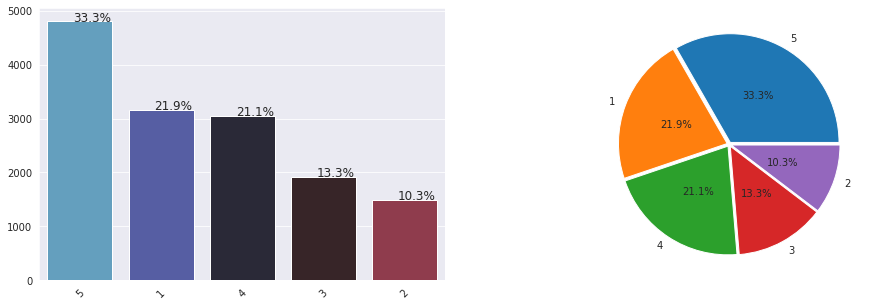

In [5]:
make_plots(df.label)

# Cleaning

In [6]:
stemmer = nltk.stem.PorterStemmer()
STOPWORDS = nltk.corpus.stopwords.words("english")

# Function to clean the data
def clean_data(txt):
    txt = txt.lower()                             # lowering text
    txt = re.sub(r'\n', ' ', txt)                 # Removing Newline
    txt = re.sub(r"[^a-zA-Z0-9]"," ", txt)        # Removing all special characters
    txt = " ".join([i for i in txt.split() if i not in STOPWORDS])   # Removing stopwrods
    return txt

def stem_text(txt):
    txt = txt.split()
    txt = [stemmer.stem(i) for i in txt]
    txt = " ".join(txt)
    return txt

In [7]:
df.text = df.text.apply(clean_data)

In [8]:
df["stemmed_text"] = df.text.apply(stem_text)

In [9]:
df.head()

,text,label,stemmed_text
0,catheterization laboratory events hospital out...,4,catheter laboratori event hospit outcom direct...
1,renal abscess children three cases renal absce...,5,renal abscess children three case renal absces...
2,hyperplastic polyps seen sigmoidoscopy markers...,2,hyperplast polyp seen sigmoidoscopi marker add...
3,subclavian artery innominate vein fistula inse...,5,subclavian arteri innomin vein fistula insert ...
4,effect local inhibition gamma aminobutyric aci...,4,effect local inhibit gamma aminobutyr acid upt...


# Vectorization

In [10]:
all_data = {}

### BOW

In [11]:
BOW = CountVectorizer(max_features=2000)
X_BOW = BOW.fit_transform(df.text)
X_BOW_stem = BOW.fit_transform(df.stemmed_text)

### TF-IDF

In [12]:
TFIDF = TfidfVectorizer(max_features=2000)
X_TFIDF = TFIDF.fit_transform(df.text)
X_TFIDF_stem = TFIDF.fit_transform(df.stemmed_text)

### Word2Vec

In [13]:
def tokenize(txt):
    return nltk.tokenize.word_tokenize(txt)

X = df.text.apply(tokenize)
X_stemmed = df.text.apply(tokenize)

WORD2VEC = Word2Vec(X, window=5, min_count=1, workers=4)
WORD2VEC_stemmed = Word2Vec(X_stemmed, window=5, min_count=1, workers=4)

In [14]:
X_WORD2VEC = []
for sent in X:
  vec = []
  for word in sent:
    vec.append(WORD2VEC[word].mean())
  X_WORD2VEC.append(vec)

X_WORD2VEC_stemmed = []
for sent in X_stemmed:
  vec = []
  for word in sent:
    vec.append(WORD2VEC_stemmed[word].mean())
  X_WORD2VEC_stemmed.append(vec)

X_WORD2VEC = pd.DataFrame(data=X_WORD2VEC).fillna(0)
X_WORD2VEC_stemmed = pd.DataFrame(data=X_WORD2VEC_stemmed).fillna(0)

### Glove

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-06 11:44:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-06 11:44:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-06 11:44:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [17]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [19]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.50d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [20]:
X_GLOVE = []
for sent in X:
  vec = []
  for word in sent:
    try:
      vec.append(model[word].mean())
    except:
      continue
  X_GLOVE.append(vec)

In [21]:
X_GLOVE_stemmed = []
for sent in X_stemmed:
  vec = []
  for word in sent:
    try:
      vec.append(model[word].mean())
    except:
      continue
  X_GLOVE_stemmed.append(vec)

In [22]:
X_GLOVE = pd.DataFrame(data=X_GLOVE).fillna(0)
X_GLOVE_stemmed = pd.DataFrame(data=X_GLOVE_stemmed).fillna(0)

### FastText

In [23]:
from gensim.models import FastText
FASTTEXT = FastText(X, size=100)
FASTTEXT_stemmed = FastText(X_stemmed, size=100)

In [24]:
X_FASTTEXT = []
for sent in X:
  vec = []
  for word in sent:
    try:
      vec.append(FASTTEXT[word].mean())
    except:
      continue
  X_FASTTEXT.append(vec)

X_FASTTEXT_stemmed = []
for sent in X_stemmed:
  vec = []
  for word in sent:
    try:
      vec.append(FASTTEXT_stemmed[word].mean())
    except:
      continue
  X_FASTTEXT_stemmed.append(vec)

X_FASTTEXT = pd.DataFrame(data=X_FASTTEXT).fillna(0)
X_FASTTEXT_stemmed = pd.DataFrame(data=X_FASTTEXT_stemmed).fillna(0)

In [25]:
all_data["BOW"] = [X_BOW.toarray(), df.label]
all_data["BOW Stemmed"] = [X_BOW_stem.toarray(), df.label]
all_data["TF-IDF"] = [X_TFIDF.toarray(), df.label]
all_data["TF-IDF Stemmed"] = [X_TFIDF_stem.toarray(), df.label]
all_data["Word2Vec"] = [X_WORD2VEC, df.label]
all_data["Word2Vec Stemmed"] = [X_WORD2VEC_stemmed, df.label]
all_data["Glove"] = [X_GLOVE, df.label]
all_data["Glove Stemmed"] = [X_GLOVE_stemmed, df.label]
all_data["FastText"] = [X_FASTTEXT, df.label]
all_data["FastText Stemmed"] = [X_FASTTEXT_stemmed, df.label]

# Modeling

In [26]:
# Importing Models
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Importing Evaluation matrces
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report, plot_confusion_matrix

# check the performance on diffrent regressor
models = []
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('SVC', SVC()))




+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW
--------------------------------------------------
Accuracy :  0.391
--------------------------------------------------
F1 :  [0.56828194 0.30493274 0.34328358 0.47115385 0.2629108 ]
--------------------------------------------------
Reacll :  [0.62318841 0.34343434 0.34586466 0.47804878 0.23595506]
--------------------------------------------------
Precision :  [0.52226721 0.27419355 0.34074074 0.46445498 0.29681979]
--------------------------------------------------
Confusion Matrix....
 [[129  15  12   8  43]
 [ 17  34   1   1  46]
 [ 21   5  46  18  43]
 [ 12   9  19  98  67]
 [ 68  61  57  86  84]]
--------------------------------------------------
Classification Report....
               precision 

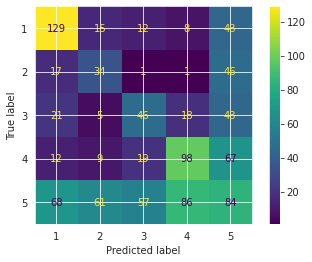

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 14.828 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW
--------------------------------------------------
Accuracy :  0.447
--------------------------------------------------
F1 :  [0.59038902 0.33684211 0.36666667 0.53828306 0.35897436]
--------------------------------------------------
Reacll :  [0.62318841 0.32323232 0.33082707 0.56585366 0.35393258]
--------------------------------------------------
Precision :  [0.56086957 0.35164835 0.41121495 0.51327434 0.36416185]
--------------------------------------------------
Confusion Matrix....
 [[129  12  

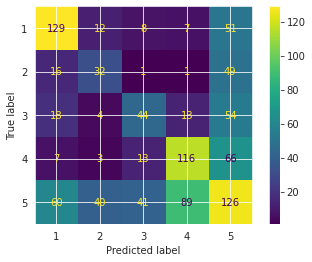

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 42.038 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW
--------------------------------------------------
Accuracy :  0.518
--------------------------------------------------
F1 :  [0.66981132 0.30857143 0.42477876 0.5959596  0.46983312]
--------------------------------------------------
Reacll :  [0.68599034 0.27272727 0.36090226 0.57560976 0.51404494]
--------------------------------------------------
Precision :  [0.65437788 0.35526316 0.51612903 0.61780105 0.43262411]
--------------------------------------------------
Confusion Matrix....
 [[142   5   5   1  54]
 [ 12  

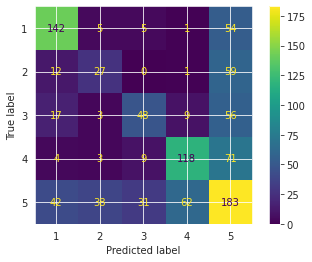

							-----------------------------------------------------------
							 Time for detection (SVC) : 375.535 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW Stemmed
--------------------------------------------------
Accuracy :  0.393
--------------------------------------------------
F1 :  [0.55263158 0.29090909 0.35714286 0.48058252 0.2721519 ]
--------------------------------------------------
Reacll :  [0.60869565 0.32323232 0.37593985 0.48292683 0.24157303]
--------------------------------------------------
Precision :  [0.5060241  0.26446281 0.34013605 0.47826087 0.3115942 ]
--------------------------------------------------
Confusion Matrix....
 [[126  15  15   9  42

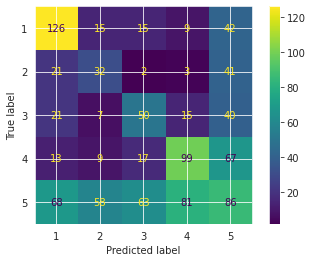

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 15.174 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW Stemmed
--------------------------------------------------
Accuracy :  0.459
--------------------------------------------------
F1 :  [0.60229885 0.31578947 0.4        0.5415677  0.38068182]
--------------------------------------------------
Reacll :  [0.63285024 0.3030303  0.37593985 0.55609756 0.37640449]
--------------------------------------------------
Precision :  [0.5745614  0.32967033 0.42735043 0.52777778 0.38505747]
--------------------------------------------------
Confusion Matrix....
 [[1

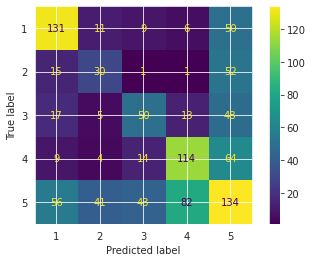

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 38.591 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  BOW Stemmed
--------------------------------------------------
Accuracy :  0.522
--------------------------------------------------
F1 :  [0.6713948  0.33898305 0.43478261 0.59949622 0.4683053 ]
--------------------------------------------------
Reacll :  [0.68599034 0.3030303  0.37593985 0.5804878  0.50842697]
--------------------------------------------------
Precision :  [0.65740741 0.38461538 0.51546392 0.61979167 0.43405276]
--------------------------------------------------
Confusion Matrix....
 [[142   5   6   1  53]

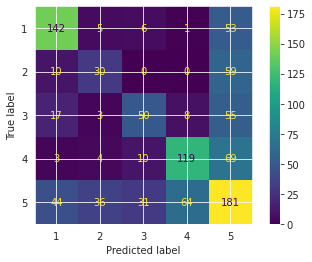

							-----------------------------------------------------------
							 Time for detection (SVC) : 357.969 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF
--------------------------------------------------
Accuracy :  0.403
--------------------------------------------------
F1 :  [0.55233853 0.33484163 0.32234432 0.48674699 0.30218069]
--------------------------------------------------
Reacll :  [0.59903382 0.37373737 0.33082707 0.49268293 0.27247191]
--------------------------------------------------
Precision :  [0.51239669 0.30327869 0.31428571 0.48095238 0.33916084]
--------------------------------------------------
Confusion Matrix....
 [[124  14  13   8  48]
 [ 

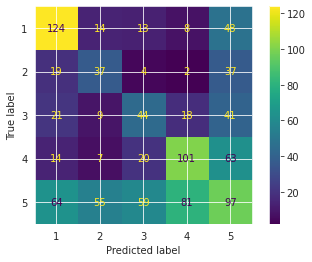

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 20.387 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF
--------------------------------------------------
Accuracy :  0.446
--------------------------------------------------
F1 :  [0.59584296 0.31914894 0.35983264 0.51972158 0.37235543]
--------------------------------------------------
Reacll :  [0.62318841 0.3030303  0.32330827 0.54634146 0.37078652]
--------------------------------------------------
Precision :  [0.57079646 0.33707865 0.40566038 0.49557522 0.37393768]
--------------------------------------------------
Confusion Matrix....
 [[129  1

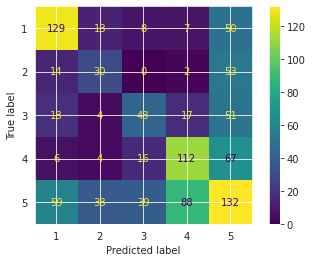

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 46.961 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF
--------------------------------------------------
Accuracy :  0.515
--------------------------------------------------
F1 :  [0.64470588 0.39361702 0.42798354 0.60049628 0.4534413 ]
--------------------------------------------------
Reacll :  [0.66183575 0.37373737 0.39097744 0.5902439  0.47191011]
--------------------------------------------------
Precision :  [0.62844037 0.41573034 0.47272727 0.61111111 0.43636364]
--------------------------------------------------
Confusion Matrix....
 [[137   7   6   2  55]
 [ 1

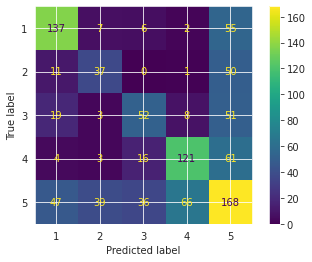

							-----------------------------------------------------------
							 Time for detection (SVC) : 372.812 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF Stemmed
--------------------------------------------------
Accuracy :  0.4
--------------------------------------------------
F1 :  [0.54788419 0.25471698 0.34782609 0.48888889 0.31306991]
--------------------------------------------------
Reacll :  [0.5942029  0.27272727 0.36090226 0.48292683 0.28932584]
--------------------------------------------------
Precision :  [0.50826446 0.23893805 0.33566434 0.495      0.3410596 ]
--------------------------------------------------
Confusion Matrix....
 [[123  17  13   8  4

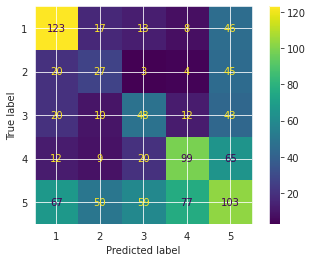

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 18.071 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF Stemmed
--------------------------------------------------
Accuracy :  0.455
--------------------------------------------------
F1 :  [0.60465116 0.32291667 0.3697479  0.53364269 0.38081805]
--------------------------------------------------
Reacll :  [0.62801932 0.31313131 0.33082707 0.56097561 0.37921348]
--------------------------------------------------
Precision :  [0.58295964 0.33333333 0.41904762 0.50884956 0.38243626]
--------------------------------------------------
Confusion Matrix....
 

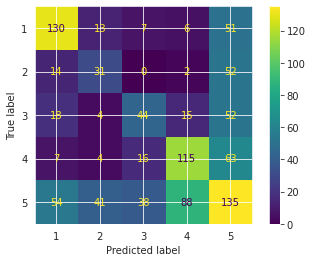

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 45.154 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  TF-IDF Stemmed
--------------------------------------------------
Accuracy :  0.535
--------------------------------------------------
F1 :  [0.68065268 0.39784946 0.45967742 0.61501211 0.4640884 ]
--------------------------------------------------
Reacll :  [0.70531401 0.37373737 0.42857143 0.6195122  0.47191011]
--------------------------------------------------
Precision :  [0.65765766 0.42528736 0.49565217 0.61057692 0.45652174]
--------------------------------------------------
Confusion Matrix....
 [[146   6   6   2  

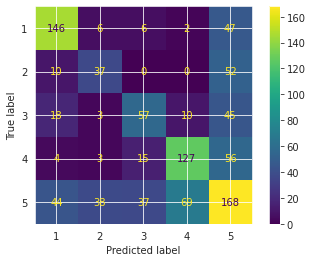

							-----------------------------------------------------------
							 Time for detection (SVC) : 371.192 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec
--------------------------------------------------
Accuracy :  0.139
--------------------------------------------------
F1 :  [0.21645022 0.04310345 0.12162162 0.17831325 0.09747899]
--------------------------------------------------
Reacll :  [0.24154589 0.05050505 0.13533835 0.1804878  0.08146067]
--------------------------------------------------
Precision :  [0.19607843 0.03759398 0.11042945 0.17619048 0.12133891]
--------------------------------------------------
Confusion Matrix....
 [[50 28 32 38 59]
 [31  

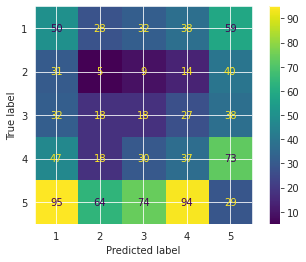

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 4.859 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec
--------------------------------------------------
Accuracy :  0.217
--------------------------------------------------
F1 :  [0.12979351 0.         0.         0.2720403  0.30420712]
--------------------------------------------------
Reacll :  [0.10628019 0.         0.         0.26341463 0.39606742]
--------------------------------------------------
Precision :  [0.16666667 0.         0.         0.28125    0.2469352 ]
--------------------------------------------------
Confusion Matrix....
 [[ 22  

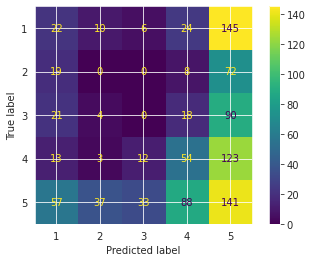

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 20.847 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec
--------------------------------------------------
Accuracy :  0.328
--------------------------------------------------
F1 :  [0.         0.         0.         0.26332288 0.47194719]
--------------------------------------------------
Reacll :  [0.         0.         0.         0.20487805 0.80337079]
--------------------------------------------------
Precision :  [0.         0.         0.         0.36842105 0.33411215]
--------------------------------------------------
Confusion Matrix....
 [[  0   0   0   6 201]
 [

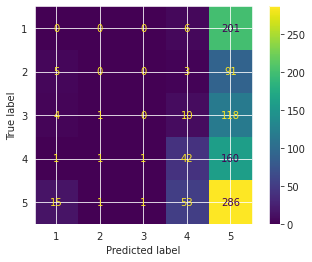

							-----------------------------------------------------------
							 Time for detection (SVC) : 167.212 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec Stemmed
--------------------------------------------------
Accuracy :  0.152
--------------------------------------------------
F1 :  [0.22559653 0.04424779 0.06949807 0.21130221 0.13292117]
--------------------------------------------------
Reacll :  [0.25120773 0.05050505 0.06766917 0.2097561  0.12078652]
--------------------------------------------------
Precision :  [0.20472441 0.03937008 0.07142857 0.21287129 0.14776632]
--------------------------------------------------
Confusion Matrix....
 [[ 52  21  27  3

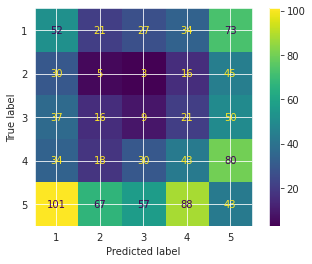

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 5.324 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec Stemmed
--------------------------------------------------
Accuracy :  0.221
--------------------------------------------------
F1 :  [0.13793103 0.         0.         0.28198433 0.30555556]
--------------------------------------------------
Reacll :  [0.11594203 0.         0.         0.26341463 0.40168539]
--------------------------------------------------
Precision :  [0.17021277 0.         0.         0.30337079 0.24655172]
--------------------------------------------------
Confusion Matrix....


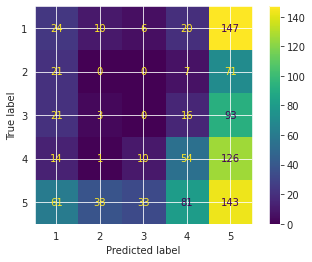

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 22.131 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  Word2Vec Stemmed
--------------------------------------------------
Accuracy :  0.336
--------------------------------------------------
F1 :  [0.         0.         0.         0.30409357 0.47811448]
--------------------------------------------------
Reacll :  [0.         0.         0.         0.25365854 0.79775281]
--------------------------------------------------
Precision :  [0.         0.         0.         0.37956204 0.34134615]
--------------------------------------------------
Confusion Matrix....
 [[  0   0   0  13

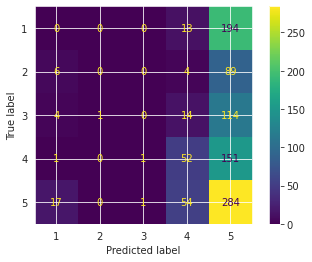

							-----------------------------------------------------------
							 Time for detection (SVC) : 152.514 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove
--------------------------------------------------
Accuracy :  0.16
--------------------------------------------------
F1 :  [0.24561404 0.05555556 0.07575758 0.20547945 0.13738019]
--------------------------------------------------
Reacll :  [0.2705314  0.06060606 0.07518797 0.2195122  0.12078652]
--------------------------------------------------
Precision :  [0.2248996  0.05128205 0.07633588 0.19313305 0.15925926]
--------------------------------------------------
Confusion Matrix....
 [[ 56  26  26  39  60]
 [ 33

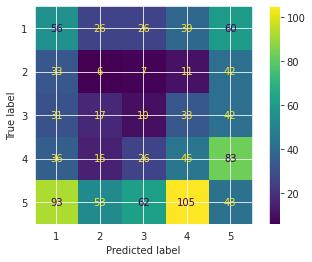

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 3.987 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove
--------------------------------------------------
Accuracy :  0.215
--------------------------------------------------
F1 :  [0.19098143 0.         0.         0.1978022  0.31086957]
--------------------------------------------------
Reacll :  [0.17391304 0.         0.         0.17560976 0.40168539]
--------------------------------------------------
Precision :  [0.21176471 0.         0.         0.22641509 0.2535461 ]
--------------------------------------------------
Confusion Matrix....
 [[ 36  11 

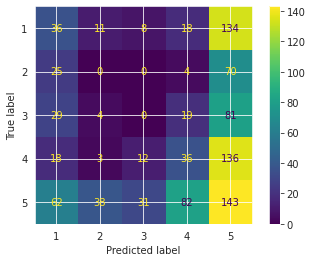

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 18.477 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove
--------------------------------------------------
Accuracy :  0.304
--------------------------------------------------
F1 :  [0.13377926 0.         0.         0.11510791 0.45462256]
--------------------------------------------------
Reacll :  [0.09661836 0.         0.         0.07804878 0.75280899]
--------------------------------------------------
Precision :  [0.2173913  0.         0.         0.21917808 0.32563791]
--------------------------------------------------
Confusion Matrix....
 [[ 20   4   0   5 178]
 [ 17

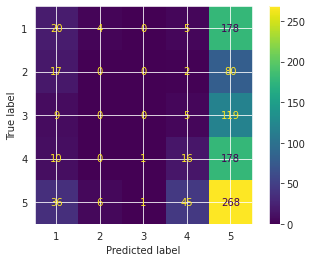

							-----------------------------------------------------------
							 Time for detection (SVC) : 131.949 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove Stemmed
--------------------------------------------------
Accuracy :  0.154
--------------------------------------------------
F1 :  [0.23829787 0.05529954 0.08988764 0.19815668 0.12091503]
--------------------------------------------------
Reacll :  [0.2705314  0.06060606 0.09022556 0.2097561  0.10393258]
--------------------------------------------------
Precision :  [0.21292776 0.05084746 0.08955224 0.18777293 0.14453125]
--------------------------------------------------
Confusion Matrix....
 [[ 56  29  27  31  

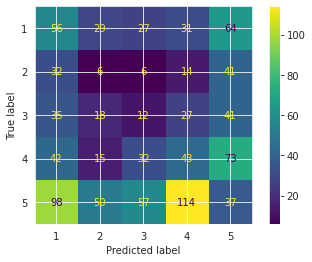

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 3.933 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove Stemmed
--------------------------------------------------
Accuracy :  0.213
--------------------------------------------------
F1 :  [0.20207254 0.         0.01052632 0.19946092 0.30055249]
--------------------------------------------------
Reacll :  [0.1884058  0.         0.0075188  0.1804878  0.38202247]
--------------------------------------------------
Precision :  [0.21787709 0.         0.01754386 0.22289157 0.24772313]
--------------------------------------------------
Confusion Matrix....
 [[

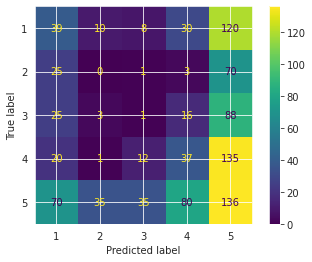

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 19.856 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  Glove Stemmed
--------------------------------------------------
Accuracy :  0.304
--------------------------------------------------
F1 :  [0.13377926 0.         0.         0.11510791 0.45462256]
--------------------------------------------------
Reacll :  [0.09661836 0.         0.         0.07804878 0.75280899]
--------------------------------------------------
Precision :  [0.2173913  0.         0.         0.21917808 0.32563791]
--------------------------------------------------
Confusion Matrix....
 [[ 20   4   0   5 17

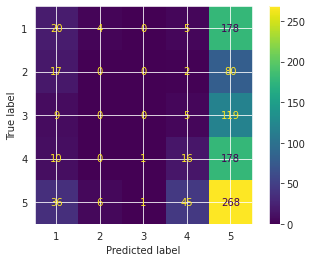

							-----------------------------------------------------------
							 Time for detection (SVC) : 142.748 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText
--------------------------------------------------
Accuracy :  0.16
--------------------------------------------------
F1 :  [0.21786492 0.05240175 0.08540925 0.23095823 0.14423077]
--------------------------------------------------
Reacll :  [0.24154589 0.06060606 0.09022556 0.22926829 0.12640449]
--------------------------------------------------
Precision :  [0.1984127  0.04615385 0.08108108 0.23267327 0.16791045]
--------------------------------------------------
Confusion Matrix....
 [[50 27 30 37 63]
 [31  6

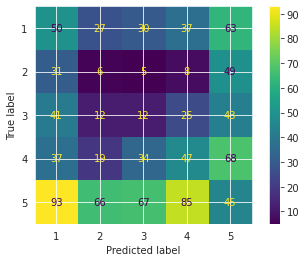

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 4.281 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText
--------------------------------------------------
Accuracy :  0.216
--------------------------------------------------
F1 :  [0.10746269 0.         0.         0.29441624 0.29850746]
--------------------------------------------------
Reacll :  [0.08695652 0.         0.         0.28292683 0.39325843]
--------------------------------------------------
Precision :  [0.140625   0.         0.         0.30687831 0.24054983]
--------------------------------------------------
Confusion Matrix....
 [[ 18  

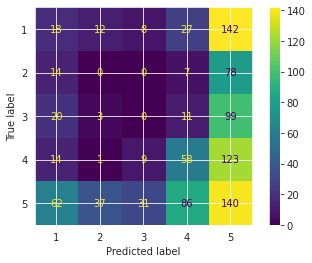

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 19.628 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText
--------------------------------------------------
Accuracy :  0.305
--------------------------------------------------
F1 :  [0.00847458 0.         0.         0.23076923 0.44688027]
--------------------------------------------------
Reacll :  [0.00483092 0.         0.         0.1902439  0.74438202]
--------------------------------------------------
Precision :  [0.03448276 0.         0.         0.29323308 0.31927711]
--------------------------------------------------
Confusion Matrix....
 [[  1   2   0  18 186]
 [

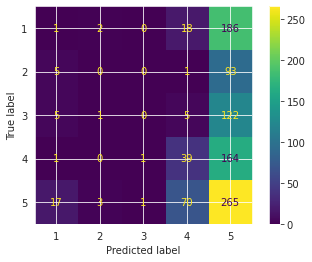

							-----------------------------------------------------------
							 Time for detection (SVC) : 158.971 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			1-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText Stemmed
--------------------------------------------------
Accuracy :  0.146
--------------------------------------------------
F1 :  [0.2        0.01793722 0.10702341 0.19164619 0.14170692]
--------------------------------------------------
Reacll :  [0.2173913  0.02020202 0.12030075 0.1902439  0.12359551]
--------------------------------------------------
Precision :  [0.18518519 0.01612903 0.09638554 0.19306931 0.16603774]
--------------------------------------------------
Confusion Matrix....
 [[45 35 38 30 59

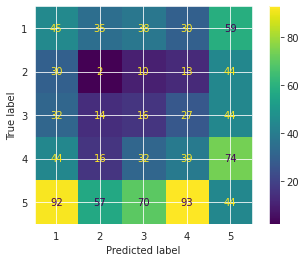

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 3.7 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText Stemmed
--------------------------------------------------
Accuracy :  0.223
--------------------------------------------------
F1 :  [0.16524217 0.         0.0106383  0.25       0.31364125]
--------------------------------------------------
Reacll :  [0.14009662 0.         0.0075188  0.22926829 0.41011236]
--------------------------------------------------
Precision :  [0.20138889 0.         0.01818182 0.2748538  0.25391304]
--------------------------------------------------
Confusion Matrix....
 [

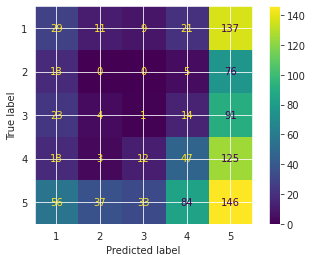

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 18.498 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For SVC The Performance result is: 
+ ==================================================================================================== +
Data Name :  FastText Stemmed
--------------------------------------------------
Accuracy :  0.309
--------------------------------------------------
F1 :  [0.0546875  0.         0.         0.20578778 0.45416316]
--------------------------------------------------
Reacll :  [0.03381643 0.         0.         0.15609756 0.75842697]
--------------------------------------------------
Precision :  [0.14285714 0.         0.         0.30188679 0.32412965]
--------------------------------------------------
Confusion Matrix....
 [[  7   3   0   7

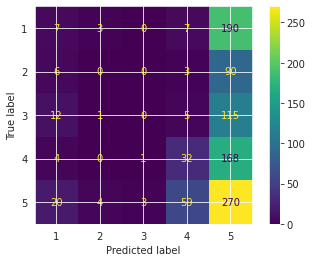

							-----------------------------------------------------------
							 Time for detection (SVC) : 152.984 seconds...
							-----------------------------------------------------------



In [27]:
# metrices to store performance
acc = []
pre = []
f1 = []
con = []
rec = []
models_name = []
datas_name = []

for data_name, data in all_data.items():
  X, y = np.array(data[0]), np.array(data[1])
  X_train, X_test = X[:-1000, :], X[-1000:, :]
  y_train, y_test = y[:-1000], y[-1000:]

  i = 0
  for name,model in models:
      i = i+1
      start_time = time.time()
      
      models_name.append(name)
      datas_name.append(data_name)
      # Fitting model to the Training set
      clf = model
      clf.fit(X_train, y_train)
      
      # predict values
      y_pred = clf.predict(X_test)
      
      # Accuracy
      accuracy = accuracy_score(y_test, y_pred)
      acc.append(accuracy)
      # Precision
      precision = precision_score(y_test, y_pred, average=None)
      pre.append(precision)
      # Recall
      recall = recall_score(y_test, y_pred, average=None)
      rec.append(recall)
      # F1 Score
      f1_sco = f1_score(y_test, y_pred, average=None)
      f1.append(f1_sco)
      # Confusion Matrix
      confusion_mat = confusion_matrix(y_test, y_pred)
      con.append(confusion_mat)
      # Report
      report = classification_report(y_test, y_pred)


      print("+","="*100,"+")
      print('\033[1m' + f"\t\t\t{i}-For {name} The Performance result is: " + '\033[0m')
      print("+","="*100,"+")
      print('Data Name : ', data_name)   
      print("-"*50)
      print('Accuracy : ', accuracy)   
      print("-"*50)
      print('F1 : ', f1_sco)
      print("-"*50)
      print('Reacll : ', recall)
      print("-"*50)
      print('Precision : ', precision)
      print("-"*50)
      print('Confusion Matrix....\n', confusion_mat)
      print("-"*50)
      print('Classification Report....\n', report)
      print("-"*50)
      print('Plotting Confusion Matrix...\n')
      plot_confusion_matrix(clf, X_test, y_test)
      plt.show()

      print("\t\t\t\t\t\t\t-----------------------------------------------------------")
      print(f"\t\t\t\t\t\t\t Time for detection ({name}) : {round((time.time() - start_time), 3)} seconds...")
      print("\t\t\t\t\t\t\t-----------------------------------------------------------")
      print()

In [28]:
comp = pd.DataFrame({"Data": datas_name, "Model": models_name, "Accuracy": acc, "Precision": pre, "Recall": rec, "F1_Score": f1, "Confusion Matrix": con})
comp

,Data,Model,Accuracy,Precision,Recall,F1_Score,Confusion Matrix
0,BOW,DecisionTreeClassifier,0.391,"[0.5222672064777328, 0.27419354838709675, 0.34...","[0.6231884057971014, 0.3434343434343434, 0.345...","[0.5682819383259912, 0.30493273542600896, 0.34...","[[129, 15, 12, 8, 43], [17, 34, 1, 1, 46], [21..."
1,BOW,RandomForestClassifier,0.447,"[0.5608695652173913, 0.3516483516483517, 0.411...","[0.6231884057971014, 0.32323232323232326, 0.33...","[0.5903890160183066, 0.3368421052631579, 0.366...","[[129, 12, 8, 7, 51], [16, 32, 1, 1, 49], [18,..."
2,BOW,SVC,0.518,"[0.6543778801843319, 0.35526315789473684, 0.51...","[0.6859903381642513, 0.2727272727272727, 0.360...","[0.669811320754717, 0.30857142857142855, 0.424...","[[142, 5, 5, 1, 54], [12, 27, 0, 1, 59], [17, ..."
3,BOW Stemmed,DecisionTreeClassifier,0.393,"[0.5060240963855421, 0.2644628099173554, 0.340...","[0.6086956521739131, 0.32323232323232326, 0.37...","[0.5526315789473684, 0.2909090909090909, 0.357...","[[126, 15, 15, 9, 42], [21, 32, 2, 3, 41], [21..."
4,BOW Stemmed,RandomForestClassifier,0.459,"[0.5745614035087719, 0.32967032967032966, 0.42...","[0.6328502415458938, 0.30303030303030304, 0.37...","[0.6022988505747127, 0.3157894736842105, 0.4, ...","[[131, 11, 9, 6, 50], [15, 30, 1, 1, 52], [17,..."
5,BOW Stemmed,SVC,0.522,"[0.6574074074074074, 0.38461538461538464, 0.51...","[0.6859903381642513, 0.30303030303030304, 0.37...","[0.6713947990543736, 0.3389830508474576, 0.434...","[[142, 5, 6, 1, 53], [10, 30, 0, 0, 59], [17, ..."
6,TF-IDF,DecisionTreeClassifier,0.403,"[0.512396694214876, 0.30327868852459017, 0.314...","[0.5990338164251208, 0.37373737373737376, 0.33...","[0.5523385300668151, 0.33484162895927605, 0.32...","[[124, 14, 13, 8, 48], [19, 37, 4, 2, 37], [21..."
7,TF-IDF,RandomForestClassifier,0.446,"[0.5707964601769911, 0.33707865168539325, 0.40...","[0.6231884057971014, 0.30303030303030304, 0.32...","[0.5958429561200924, 0.3191489361702128, 0.359...","[[129, 13, 8, 7, 50], [14, 30, 0, 2, 53], [18,..."
8,TF-IDF,SVC,0.515,"[0.6284403669724771, 0.4157303370786517, 0.472...","[0.6618357487922706, 0.37373737373737376, 0.39...","[0.6447058823529412, 0.39361702127659576, 0.42...","[[137, 7, 6, 2, 55], [11, 37, 0, 1, 50], [19, ..."
9,TF-IDF Stemmed,DecisionTreeClassifier,0.400,"[0.5082644628099173, 0.23893805309734514, 0.33...","[0.5942028985507246, 0.2727272727272727, 0.360...","[0.5478841870824053, 0.25471698113207547, 0.34...","[[123, 17, 13, 8, 46], [20, 27, 3, 4, 45], [20..."
